
Zadanie polega na stworzeniu modelu, który będzie klasyfikował liczbę gwiazdek przyznanych hotelowi (rating, klasa = liczba_gwiazdek - 1) na podstawie recenzji, jaką otrzymał (review).
Wszelkie chwyty dozwolone :) Mogą Państwo przewidywać klasy w oparciu o klasyczną metodę bag of words, inne metody reprezentacji dokumentów (np. TF-IDF), korzystać z embeddingów, gotowych modeli językowych itd. Do dyspozycji mają Państwo dane treningowe, oczekuję od Państwa pliku csv z wygenerowanymi predykcjami.
Proszę zwrócić uwagę na fakt, że jest to problem klasyfikacji wieloklasowej z mocno niezbalansowanym zbiorem danych!
Proszę także Państwa o przetestowanie kilku (co najmniej trzech) podejść do klasyfikacji - mogą (ale nie muszą!) być to gotowe modele, najlepiej o różnych architekturach.

Bardzo proszę, żeby zwrócili mi Państwo archiwum zip (wystarczy jedna osoba z zespołu), proszę też o zastosowanie się do instrukcji:
- Archiwum i wszystkie pliki powinny być nazwane {poniedzialek/piatek}_nazwisko1_nazwisko2
- W archiwum proszę (bez zbędnych podfolderów!) umieścić pliki ze swoim kodem i testowe predykcje nazwane zgodnie z sekwencją  {poniedzialek/piatek}_nazwisko1_nazwisko2.csv
- Testowe predykcje powinny mieć kolejność zgodną z kolejnością sekwencji, do których się odnoszą w zbiorze testowym. Plik csv nie powinien mieć nagłówka ani indeksów.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup, AutoTokenizer, AutoModelForSeq2SeqLM
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
import evaluate
from tqdm import tqdm
import math
import random

In [2]:
random.seed(42)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
device

device(type='cuda')

In [4]:
df_train_data = pd.read_csv("train_data.csv")
df_train_data["rating"].astype(float)
df_train_data["class"] = df_train_data["rating"]
classes_num = len(df_train_data["class"].unique())
df_train_data.head()

,review,rating,class
0,location not palace excellent hotel booke dthe...,4,4
1,respite definitely not place stay looking ultr...,3,3
2,stunning truly memorable spot right beach nusa...,4,4
3,solid business hotel near embassy stayed hotel...,3,3
4,nice place make sure lock money warning money ...,3,3


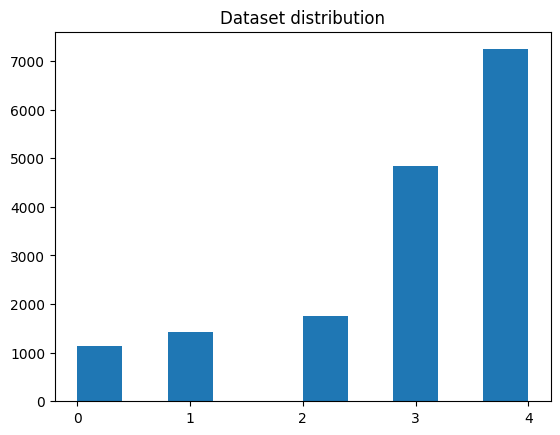

In [5]:
fig = plt.Figure()
plt.hist(df_train_data["class"].values)
plt.title("Dataset distribution")
plt.xticks([0,1,2,3,4])
plt.show()

In [6]:
reviews = df_train_data['review'].tolist()
ratings = df_train_data['rating'].tolist()
train_texts, val_texts, train_labels, val_labels = train_test_split(reviews, ratings, test_size=0.2,random_state=42)

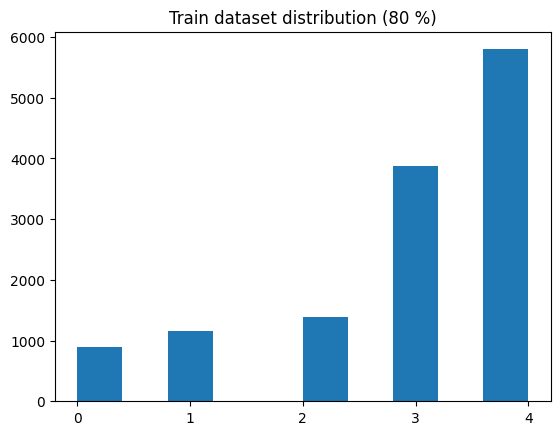

In [7]:
fig = plt.Figure()
plt.hist(train_labels)
plt.title("Train dataset distribution (80 %)")
plt.xticks([0,1,2,3,4])
plt.show()

In [8]:
# model i tokenizer użyty to parafrazowania klas o mniejszej reprezentacji
tokenizer_t2t = AutoTokenizer.from_pretrained("humarin/chatgpt_paraphraser_on_T5_base")
model_t2t = AutoModelForSeq2SeqLM.from_pretrained("humarin/chatgpt_paraphraser_on_T5_base").to(device)


def paraphrase(
    question,
    num_beams=5,
    num_beam_groups=5,
    num_return_sequences=5,
    repetition_penalty=10.0,
    diversity_penalty=3.0,
    no_repeat_ngram_size=2,
    temperature=0.7,
    max_length=64,
):
    input_ids = tokenizer_t2t(
        f'paraphrase: {question}',
        return_tensors="pt", padding="longest",
        max_length=max_length,
        truncation=True,
    ).input_ids.to(device)
    
    outputs = model_t2t.generate(
        input_ids, temperature=temperature, repetition_penalty=repetition_penalty,
        num_return_sequences=num_return_sequences, no_repeat_ngram_size=no_repeat_ngram_size,
        num_beams=num_beams, num_beam_groups=num_beam_groups,
        max_length=max_length, diversity_penalty=diversity_penalty
    )

    res = tokenizer_t2t.batch_decode(outputs, skip_special_tokens=True)

    return res


In [9]:
# Zajmuje dużo czasu, więc trzeba wyeksportować
# max_count = len([index for index, value in enumerate(train_labels) if value == 4])
# new_sentences = []
# new_labels = []

# for class_num in [0,1,2]:
#     indices = [index for index, value in enumerate(train_labels) if value == class_num]
#     paraphrases_num = math.floor(max_count/len(indices))
#     sentences = [train_texts[i] for i in indices]
#     for sentence in tqdm(sentences):
#         result = paraphrase(sentence, num_beams=paraphrases_num, num_beam_groups=paraphrases_num, num_return_sequences=paraphrases_num)
#         new_sentences.extend(result)
#         new_labels.extend([class_num]*paraphrases_num)
    




In [10]:
# new_train_texts = train_texts
# new_train_texts.extend(new_sentences)
# new_train_labels = train_labels
# new_train_labels.extend(new_labels)

# paraphrased_df = pd.DataFrame({"review":new_train_texts, "rating":new_train_labels})
# paraphrased_df.to_csv("paraphrased_train.csv", index=None)

In [11]:
# Wczytanie zrównoważonego datasetu
paraphrased_df = pd.read_csv("paraphrased_train.csv")
paraphrased_df["rating"].astype(float)

train_texts_long = paraphrased_df["review"].tolist()
train_labels_long = paraphrased_df["rating"].tolist()

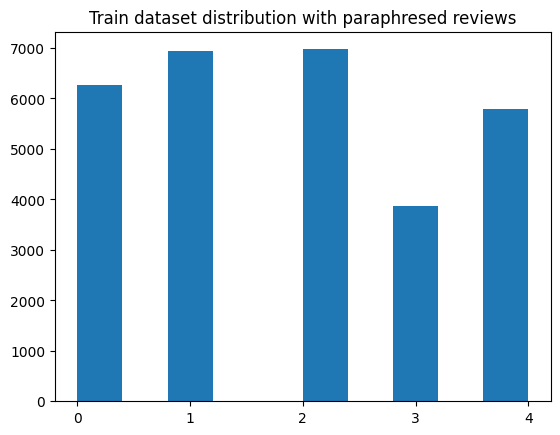

In [12]:
fig = plt.Figure()
plt.hist(train_labels_long)
plt.title("Train dataset distribution with paraphresed reviews")
plt.xticks([0,1,2,3,4])
plt.show()

In [13]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenizer

BertTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [14]:
# max len znacznie wydluza czas uczenia
class MaskedAttentionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=64):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'review': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.float)
        }

In [15]:
# train_dataset_att = MaskedAttentionDataset(train_texts, train_labels, tokenizer)
train_dataset_att = MaskedAttentionDataset(train_texts_long, train_labels_long, tokenizer)

val_dataset_att = MaskedAttentionDataset(val_texts, val_labels, tokenizer)
train_loader_att = DataLoader(train_dataset_att, batch_size=256, shuffle=True)
val_loader_att = DataLoader(val_dataset_att, batch_size=256, shuffle=False)

In [16]:
# next(iter(train_loader_att))

## Transformer (BERT)

In [21]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=classes_num).to(device)
# Trening tylko dla ostatniej warstwy
for param in model.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad=True

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [23]:
optimizer = Adam(model.parameters(), lr=0.002)
loss_fn = nn.CrossEntropyLoss()

Epoch num: 1/20


100%|██████████| 117/117 [00:57<00:00,  2.04it/s]


Validation Loss: 1.395862029148982, Validation Accuracy: 0.43915827996340345
Epoch num: 2/20


100%|██████████| 117/117 [00:56<00:00,  2.08it/s]


Validation Loss: 1.2872045040130615, Validation Accuracy: 0.46538578835010674
Epoch num: 3/20


100%|██████████| 117/117 [00:56<00:00,  2.07it/s]


Validation Loss: 1.264623000071599, Validation Accuracy: 0.45806648368405
Epoch num: 4/20


100%|██████████| 117/117 [00:56<00:00,  2.08it/s]


Validation Loss: 1.2182108347232525, Validation Accuracy: 0.4855138761817627
Epoch num: 5/20


100%|██████████| 117/117 [00:56<00:00,  2.07it/s]


Validation Loss: 1.2338473430046668, Validation Accuracy: 0.4672156145166209
Epoch num: 6/20


100%|██████████| 117/117 [00:56<00:00,  2.07it/s]


Validation Loss: 1.2003697156906128, Validation Accuracy: 0.48368405001524856
Epoch num: 7/20


100%|██████████| 117/117 [00:56<00:00,  2.08it/s]


Validation Loss: 1.2110696480824397, Validation Accuracy: 0.4800243976822202
Epoch num: 8/20


100%|██████████| 117/117 [00:56<00:00,  2.07it/s]


Validation Loss: 1.1816062377049372, Validation Accuracy: 0.4943580359865813
Epoch num: 9/20


100%|██████████| 117/117 [00:56<00:00,  2.07it/s]


Validation Loss: 1.1632459438764131, Validation Accuracy: 0.4977127172918573
Epoch num: 10/20


100%|██████████| 117/117 [00:56<00:00,  2.06it/s]


Validation Loss: 1.1866787030146673, Validation Accuracy: 0.471485208905154
Epoch num: 11/20


100%|██████████| 117/117 [00:55<00:00,  2.09it/s]


Validation Loss: 1.1561354673825777, Validation Accuracy: 0.4992375724306191
Epoch num: 12/20


100%|██████████| 117/117 [00:56<00:00,  2.07it/s]


Validation Loss: 1.1672760798380926, Validation Accuracy: 0.4855138761817627
Epoch num: 13/20


100%|██████████| 117/117 [01:01<00:00,  1.90it/s]


Validation Loss: 1.1703618122981145, Validation Accuracy: 0.494967978042086
Epoch num: 14/20


100%|██████████| 117/117 [01:57<00:00,  1.00s/it]


Validation Loss: 1.152577748665443, Validation Accuracy: 0.5035071668191522
Epoch num: 15/20


100%|██████████| 117/117 [01:54<00:00,  1.02it/s]


Validation Loss: 1.1427407631507287, Validation Accuracy: 0.5068618481244281
Epoch num: 16/20


100%|██████████| 117/117 [01:52<00:00,  1.04it/s]


Validation Loss: 1.244367425258343, Validation Accuracy: 0.4059164379383959
Epoch num: 17/20


100%|██████████| 117/117 [01:55<00:00,  1.02it/s]


Validation Loss: 1.144939165848952, Validation Accuracy: 0.5044220799024093
Epoch num: 18/20


100%|██████████| 117/117 [01:49<00:00,  1.07it/s]


Validation Loss: 1.1591169559038603, Validation Accuracy: 0.4910033546813053
Epoch num: 19/20


100%|██████████| 117/117 [01:51<00:00,  1.05it/s]


Validation Loss: 1.1372821789521437, Validation Accuracy: 0.5025922537358951
Epoch num: 20/20


100%|██████████| 117/117 [01:56<00:00,  1.00it/s]


Validation Loss: 1.1455393020923321, Validation Accuracy: 0.5099115584019518


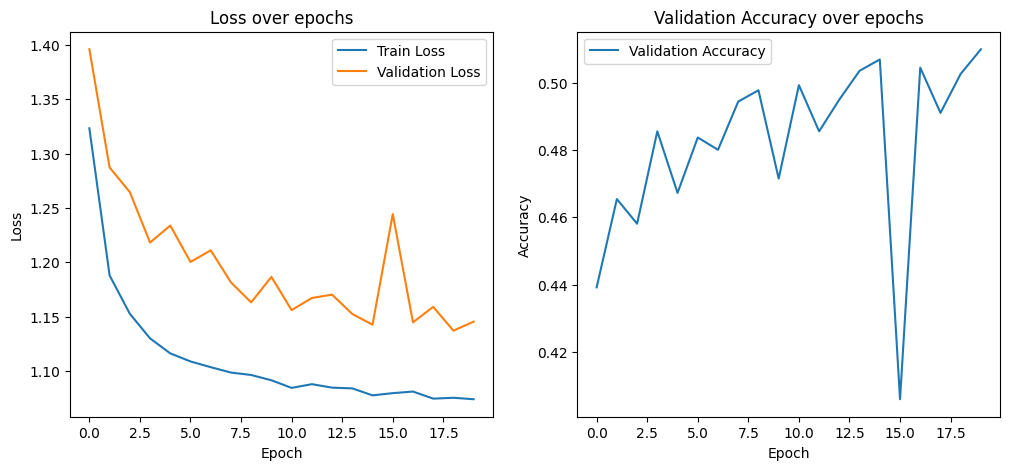

In [24]:
train_losses = []
val_losses = []
val_accuracies = []

num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    losses = []
    print("Epoch num: %s/%s" %(epoch+1, num_epochs))
    for batch in tqdm(train_loader_att):
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device).long()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = outputs.logits
        loss = loss_fn(preds, labels)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
    train_losses.append(np.mean(losses))

    model.eval()
    val_loss = 0
    val_steps = 0
    val_preds = []
    val_labels_list = []
    with torch.no_grad():
        for batch in val_loader_att:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device).long()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = outputs.logits
            loss = loss_fn(preds, labels)
            val_loss += loss.item()
            val_steps += 1

            val_preds.extend(torch.argmax(preds, dim=1).cpu().numpy())
            val_labels_list.extend(labels.cpu().numpy())

    val_losses.append(val_loss / val_steps)
    val_accuracy = accuracy_score(val_labels_list, val_preds)
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {val_loss / val_steps}, Validation Accuracy: {val_accuracy}")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### Obserwacje dla modelu transformer:
- 55% max co się udało uzyskać ze zwykłym datasetem
- skrócenie maksymalnej długości encodingu do 32 nie pogroszyło dokładności, ale skróciło czas treningu jednej epoki
- zamiana z modelu bert-base na bert-large nie poprawiło dokładności, ale znacznie wydłużyło czas treningu
- trenowanie całości zamiast tylko ostatniej warstwy nie poprawiło dokładności, ale wydłużyło czas trenowania
- dokłądność podczas treningu mocno skacze, co można poprawić, przez dłuższe uczenie z mniejszym lr
- dodanie dodatkowych sparafrazowanych danych nieznacznie poprawiło dokładność

In [ ]:
# num_epochs = 10
# for epoch in range(num_epochs):
#     losses = []
#     print("Epoch num: %s/%s" %(epoch+1, num_epochs))
#     for batch in tqdm(train_loader):
#         model.train()
#         optimizer.zero_grad()
#         # review = batch["review"].to(device)
#         input_ids = batch["input_ids"].to(device)
#         attention_mask = batch["attention_mask"].to(device)
#         labels = batch["labels"].to(device).long()
#         outputs = model(input_ids=input_ids, attention_mask=attention_mask)
#         preds = outputs.logits
#         loss = loss_fn(preds, labels)
#         losses.append(loss.item())
#         loss.backward()
#         optimizer.step()
#     print(np.mean(losses))

In [ ]:
# metric = evaluate.load("accuracy")
# model.eval()
# for batch in val_loader:
#     input_ids = batch["input_ids"].to(device)
#     attention_mask = batch["attention_mask"].to(device)
#     labels = batch["labels"].to(device).long()
#     with torch.no_grad():
#         outputs = model(input_ids=input_ids, attention_mask=attention_mask)
#         preds = outputs.logits
#         predictions = torch.argmax(preds, dim=-1)
#     metric.add_batch(predictions=predictions, references=labels)
# metric.compute()

## CNN

In [25]:


class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }



In [26]:
train_texts, val_texts, train_labels, val_labels = train_test_split(df_train_data['review'].tolist(), df_train_data['rating'].tolist(), test_size=0.2, random_state=42)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_dataset = TextDataset(train_texts, train_labels, tokenizer)
# train_dataset = TextDataset(train_texts_long, train_labels_long, tokenizer)

val_dataset = TextDataset(val_texts, val_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [27]:
class CNN_Text(nn.Module):
    def __init__(self, embed_num, embed_dim, class_num, kernel_num, kernel_sizes, dropout):
        super(CNN_Text, self).__init__()
        V = embed_num
        D = embed_dim
        C = class_num
        Ci = 1
        Co = kernel_num
        Ks = kernel_sizes

        self.embed = nn.Embedding(V, D)
        self.convs1 = nn.ModuleList([nn.Conv2d(Ci, Co, (K, D)) for K in Ks])
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(len(Ks) * Co, C)

    def forward(self, x):
        x = self.embed(x)  # (N, W, D)
        x = x.unsqueeze(1)  # (N, Ci, W, D)
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1]  # [(N, Co, W), ...]*len(Ks)
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  # [(N, Co), ...]*len(Ks)
        x = torch.cat(x, 1)
        x = self.dropout(x)
        logit = self.fc1(x)
        return logit

In [29]:
vocab_size = tokenizer.vocab_size
embed_dim = 128 # oryginalnie 128
kernel_num = 100 # oryginalnie 100
kernel_sizes = [3, 4, 5]
dropout = 0.5
class_num = classes_num

model_cnn = CNN_Text(vocab_size, embed_dim, class_num, kernel_num, kernel_sizes, dropout).to(device)
optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=0.001, weight_decay=0.004)
loss_fn = nn.CrossEntropyLoss()

100%|██████████| 410/410 [00:53<00:00,  7.60it/s]


Epoch 1 / 50, Train Loss: 1.3172882215278905, Validation Loss: 1.15192561647267, Validation Accuracy: 0.4525770051845075


100%|██████████| 410/410 [00:52<00:00,  7.85it/s]


Epoch 2 / 50, Train Loss: 1.0868099404544365, Validation Loss: 1.0112352093446602, Validation Accuracy: 0.5739554742299482


100%|██████████| 410/410 [00:53<00:00,  7.61it/s]


Epoch 3 / 50, Train Loss: 1.016746684690801, Validation Loss: 0.97708846932476, Validation Accuracy: 0.5916437938395852


100%|██████████| 410/410 [00:53<00:00,  7.73it/s]


Epoch 4 / 50, Train Loss: 0.9810955998374195, Validation Loss: 0.9712146329648287, Validation Accuracy: 0.5980481854223849


100%|██████████| 410/410 [00:53<00:00,  7.64it/s]


Epoch 5 / 50, Train Loss: 0.9559265844705628, Validation Loss: 0.9581056798546059, Validation Accuracy: 0.6068923452272034


100%|██████████| 410/410 [00:52<00:00,  7.82it/s]


Epoch 6 / 50, Train Loss: 0.940584074433257, Validation Loss: 0.9457313777173607, Validation Accuracy: 0.6093321134492223


100%|██████████| 410/410 [00:54<00:00,  7.52it/s]


Epoch 7 / 50, Train Loss: 0.9298555179340083, Validation Loss: 0.926236868483349, Validation Accuracy: 0.6041476059774321


100%|██████████| 410/410 [00:51<00:00,  7.90it/s]


Epoch 8 / 50, Train Loss: 0.9136964597353121, Validation Loss: 0.9227376204092526, Validation Accuracy: 0.6184812442817932


100%|██████████| 410/410 [00:52<00:00,  7.77it/s]


Epoch 9 / 50, Train Loss: 0.9054950314324076, Validation Loss: 0.9186104443466779, Validation Accuracy: 0.6236657517535834


100%|██████████| 410/410 [00:52<00:00,  7.74it/s]


Epoch 10 / 50, Train Loss: 0.9048613115054805, Validation Loss: 0.9097027280955639, Validation Accuracy: 0.6132967368100031


100%|██████████| 410/410 [00:50<00:00,  8.09it/s]


Epoch 11 / 50, Train Loss: 0.8990526584590354, Validation Loss: 0.8996185070102655, Validation Accuracy: 0.623360780725831


100%|██████████| 410/410 [00:51<00:00,  7.98it/s]


Epoch 12 / 50, Train Loss: 0.8983075546055306, Validation Loss: 0.9036484783135571, Validation Accuracy: 0.6184812442817932


100%|██████████| 410/410 [00:50<00:00,  8.06it/s]


Epoch 13 / 50, Train Loss: 0.8961324249825826, Validation Loss: 0.8962426255050214, Validation Accuracy: 0.6224458676425739


100%|██████████| 410/410 [00:50<00:00,  8.19it/s]


Epoch 14 / 50, Train Loss: 0.8914574524251426, Validation Loss: 0.8912912693995874, Validation Accuracy: 0.6215309545593168


100%|██████████| 410/410 [00:48<00:00,  8.40it/s]


Epoch 15 / 50, Train Loss: 0.8885819337716917, Validation Loss: 0.8909290346127112, Validation Accuracy: 0.6294602012808783


100%|██████████| 410/410 [00:48<00:00,  8.46it/s]


Epoch 16 / 50, Train Loss: 0.8864655028029186, Validation Loss: 0.8914553048541245, Validation Accuracy: 0.6254955779200976


100%|██████████| 410/410 [00:48<00:00,  8.37it/s]


Epoch 17 / 50, Train Loss: 0.8794796367970908, Validation Loss: 0.888984852624171, Validation Accuracy: 0.6248856358645929


100%|██████████| 410/410 [00:53<00:00,  7.73it/s]


Epoch 18 / 50, Train Loss: 0.8739265421541725, Validation Loss: 0.88887921062488, Validation Accuracy: 0.6236657517535834


100%|██████████| 410/410 [00:52<00:00,  7.76it/s]


Epoch 19 / 50, Train Loss: 0.8729926256144919, Validation Loss: 0.8942816135952774, Validation Accuracy: 0.6129917657822507


100%|██████████| 410/410 [00:52<00:00,  7.76it/s]


Epoch 20 / 50, Train Loss: 0.8695267203377515, Validation Loss: 0.8905934315283321, Validation Accuracy: 0.623360780725831


100%|██████████| 410/410 [00:52<00:00,  7.75it/s]


Epoch 21 / 50, Train Loss: 0.8693317619765677, Validation Loss: 0.899297486231165, Validation Accuracy: 0.6276303751143641


100%|██████████| 410/410 [00:52<00:00,  7.86it/s]


Epoch 22 / 50, Train Loss: 0.8663053525657188, Validation Loss: 0.8811626845193141, Validation Accuracy: 0.6328148825861544


100%|██████████| 410/410 [00:54<00:00,  7.57it/s]


Epoch 23 / 50, Train Loss: 0.8612009474417058, Validation Loss: 0.8846399951907038, Validation Accuracy: 0.6303751143641354


100%|██████████| 410/410 [00:51<00:00,  8.01it/s]


Epoch 24 / 50, Train Loss: 0.8586358343682639, Validation Loss: 0.8819761455637737, Validation Accuracy: 0.6297651723086307


100%|██████████| 410/410 [00:52<00:00,  7.82it/s]


Epoch 25 / 50, Train Loss: 0.8625249978972644, Validation Loss: 0.8803913610652813, Validation Accuracy: 0.6306800853918878


100%|██████████| 410/410 [00:53<00:00,  7.73it/s]


Epoch 26 / 50, Train Loss: 0.8550741515508512, Validation Loss: 0.8854154238423098, Validation Accuracy: 0.6318999695028972


100%|██████████| 410/410 [00:51<00:00,  8.03it/s]


Epoch 27 / 50, Train Loss: 0.8550769166248601, Validation Loss: 0.8828535288282968, Validation Accuracy: 0.6297651723086307


100%|██████████| 410/410 [00:50<00:00,  8.14it/s]


Epoch 28 / 50, Train Loss: 0.8552893267899024, Validation Loss: 0.8780126253378044, Validation Accuracy: 0.6264104910033547


100%|██████████| 410/410 [00:51<00:00,  7.98it/s]


Epoch 29 / 50, Train Loss: 0.8516762987869542, Validation Loss: 0.8766361729612628, Validation Accuracy: 0.6328148825861544


100%|██████████| 410/410 [00:52<00:00,  7.85it/s]


Epoch 30 / 50, Train Loss: 0.8511727093196497, Validation Loss: 0.875677507479214, Validation Accuracy: 0.6364745349191827


100%|██████████| 410/410 [00:54<00:00,  7.58it/s]


Epoch 31 / 50, Train Loss: 0.8490740658306494, Validation Loss: 0.8799895794646254, Validation Accuracy: 0.62580054894785


100%|██████████| 410/410 [00:51<00:00,  7.89it/s]


Epoch 32 / 50, Train Loss: 0.8481891323880452, Validation Loss: 0.8768791637374359, Validation Accuracy: 0.6322049405306496


100%|██████████| 410/410 [00:50<00:00,  8.19it/s]


Epoch 33 / 50, Train Loss: 0.8463229348019856, Validation Loss: 0.8788508958029515, Validation Accuracy: 0.6306800853918878


100%|██████████| 410/410 [00:51<00:00,  8.02it/s]


Epoch 34 / 50, Train Loss: 0.8443415907824912, Validation Loss: 0.8751653230306015, Validation Accuracy: 0.6276303751143641


100%|██████████| 410/410 [00:53<00:00,  7.68it/s]


Epoch 35 / 50, Train Loss: 0.8414326509324516, Validation Loss: 0.8787481588067361, Validation Accuracy: 0.6236657517535834


100%|██████████| 410/410 [00:51<00:00,  7.94it/s]


Epoch 36 / 50, Train Loss: 0.8425649615322671, Validation Loss: 0.8754061848214529, Validation Accuracy: 0.6273254040866117


100%|██████████| 410/410 [00:51<00:00,  8.00it/s]


Epoch 37 / 50, Train Loss: 0.8402424655309537, Validation Loss: 0.8770530252780729, Validation Accuracy: 0.6224458676425739


100%|██████████| 410/410 [00:51<00:00,  7.90it/s]


Epoch 38 / 50, Train Loss: 0.8381622235949446, Validation Loss: 0.8772719797578831, Validation Accuracy: 0.6276303751143641


100%|██████████| 410/410 [00:53<00:00,  7.73it/s]


Epoch 39 / 50, Train Loss: 0.8392298555228769, Validation Loss: 0.8788347122738662, Validation Accuracy: 0.62580054894785


100%|██████████| 410/410 [00:52<00:00,  7.87it/s]


Epoch 40 / 50, Train Loss: 0.8334562290005567, Validation Loss: 0.8808266908219717, Validation Accuracy: 0.6236657517535834


100%|██████████| 410/410 [00:52<00:00,  7.81it/s]


Epoch 41 / 50, Train Loss: 0.8366140542960748, Validation Loss: 0.8759077197139703, Validation Accuracy: 0.6312900274473925


100%|██████████| 410/410 [00:53<00:00,  7.68it/s]


Epoch 42 / 50, Train Loss: 0.8384565197839969, Validation Loss: 0.8777696548156368, Validation Accuracy: 0.6273254040866117


100%|██████████| 410/410 [00:52<00:00,  7.81it/s]


Epoch 43 / 50, Train Loss: 0.8376564854528846, Validation Loss: 0.8796822278244981, Validation Accuracy: 0.6227508386703263


100%|██████████| 410/410 [00:49<00:00,  8.27it/s]


Epoch 44 / 50, Train Loss: 0.835794086136469, Validation Loss: 0.877493156970126, Validation Accuracy: 0.6254955779200976


100%|██████████| 410/410 [00:52<00:00,  7.76it/s]


Epoch 45 / 50, Train Loss: 0.8358506851079988, Validation Loss: 0.8805960584612726, Validation Accuracy: 0.6285452881976212


100%|██████████| 410/410 [00:51<00:00,  7.93it/s]


Epoch 46 / 50, Train Loss: 0.8312700213455573, Validation Loss: 0.8797271674119153, Validation Accuracy: 0.6358645928636779


100%|██████████| 410/410 [00:53<00:00,  7.68it/s]


Epoch 47 / 50, Train Loss: 0.8362385438709724, Validation Loss: 0.8751340994557131, Validation Accuracy: 0.6306800853918878


100%|██████████| 410/410 [00:53<00:00,  7.64it/s]


Epoch 48 / 50, Train Loss: 0.8304752916824527, Validation Loss: 0.8744288544053013, Validation Accuracy: 0.6242756938090881


100%|██████████| 410/410 [00:47<00:00,  8.69it/s]


Epoch 49 / 50, Train Loss: 0.8250016087439002, Validation Loss: 0.8759355759157718, Validation Accuracy: 0.6267154620311071


100%|██████████| 410/410 [00:45<00:00,  9.06it/s]


Epoch 50 / 50, Train Loss: 0.8301716074710939, Validation Loss: 0.8776967062533481, Validation Accuracy: 0.6303751143641354


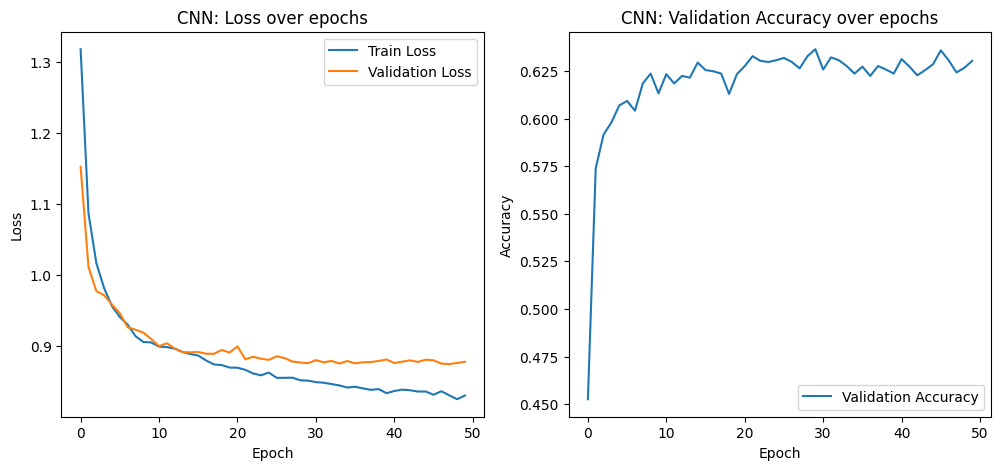

In [30]:
train_losses_cnn = []
val_losses_cnn = []
val_accuracies_cnn = []

num_epochs = 50
for epoch in range(num_epochs):
    model_cnn.train()
    losses = []
    for batch in tqdm(train_loader):
        optimizer_cnn.zero_grad()
        input_ids = batch["input_ids"].to(device)
        labels = batch["labels"].to(device)
        outputs = model_cnn(input_ids)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer_cnn.step()
        losses.append(loss.item())
    train_losses_cnn.append(np.mean(losses))

    model_cnn.eval()
    val_loss = 0
    val_steps = 0
    val_preds = []
    val_labels_list = []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            outputs = model_cnn(input_ids)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()
            val_steps += 1

            val_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            val_labels_list.extend(labels.cpu().numpy())

    val_losses_cnn.append(val_loss / val_steps)
    val_accuracy = accuracy_score(val_labels_list, val_preds)
    val_accuracies_cnn.append(val_accuracy)
    print(f'Epoch {epoch+1} / {num_epochs}, Train Loss: {np.mean(losses)}, Validation Loss: {val_loss / val_steps}, Validation Accuracy: {val_accuracy}')

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses_cnn, label='Train Loss')
plt.plot(val_losses_cnn, label='Validation Loss')
plt.title('CNN: Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies_cnn, label='Validation Accuracy')
plt.title('CNN: Validation Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### CNN wnioski
- 65% dokładności
- dodanie sparafrazowanych tekstów poprawiło dokładność, ale jest to zależne również od innych parametrów
- zmniejszenie długości embeddingu przyspieszyło uczenie, ale pogorszyło dokładność
- normalizacja L2  zapobiega przeuczeniu
- zbyt duża wartość weight_decay znacznie pogarsza dokładność

In [ ]:
# num_epochs = 10
# for epoch in range(num_epochs):
#     model_cnn.train()
#     losses = []
#     for batch in tqdm(train_loader):
#         optimizer_cnn.zero_grad()
#         input_ids = batch["input_ids"].to(device)
#         labels = batch["labels"].to(device)
#         outputs = model_cnn(input_ids)
#         loss = loss_fn(outputs, labels)
#         loss.backward()
#         optimizer_cnn.step()
#         losses.append(loss.item())
#     print(f'Epoch {epoch+1}, Loss: {np.mean(losses)}')

In [ ]:
# model_cnn.eval()
# correct_predictions = 0
# with torch.no_grad():
#     for batch in val_loader:
#         input_ids = batch["input_ids"].to(device)
#         labels = batch["labels"].to(device)
#         outputs = model_cnn(input_ids)
#         _, preds = torch.max(outputs, dim=1)
#         correct_predictions += torch.sum(preds == labels)
# print(f'Validation Accuracy: {correct_predictions.double() / len(val_dataset)}')

## LSTM

In [31]:
class LSTM_Text(nn.Module):
    def __init__(self, embed_num, embed_dim, class_num, hidden_dim, n_layers, dropout):
        super(LSTM_Text, self).__init__()
        self.embed = nn.Embedding(embed_num, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, n_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, class_num)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.embed(x)
        x, _ = self.lstm(x)
        x = self.dropout(x)
        x = self.fc(x[:, -1, :])
        return x

In [32]:
hidden_dim = 256 # oryginalnie 256
n_layers = 2 # oryginalnie 2 warstwy

model_lstm = LSTM_Text(vocab_size, embed_dim, class_num, hidden_dim, n_layers, dropout).to(device)
optimizer_lstm  = optim.Adam(model_lstm.parameters(), lr=0.001, weight_decay=0.001)
loss_fn = nn.CrossEntropyLoss()

100%|██████████| 410/410 [00:43<00:00,  9.50it/s]


Epoch 1 / 20, Train Loss: 1.362992609564851, Validation Loss: 1.363792594196727, Validation Accuracy: 0.4434278743519366


100%|██████████| 410/410 [00:43<00:00,  9.53it/s]


Epoch 2 / 20, Train Loss: 1.356542061596382, Validation Loss: 1.3541000838418609, Validation Accuracy: 0.44190301921317476


100%|██████████| 410/410 [00:46<00:00,  8.77it/s]


Epoch 3 / 20, Train Loss: 1.3462973754580427, Validation Loss: 1.3403642108139482, Validation Accuracy: 0.4455626715462031


100%|██████████| 410/410 [00:48<00:00,  8.46it/s]


Epoch 4 / 20, Train Loss: 1.3450431253851913, Validation Loss: 1.3658508455869063, Validation Accuracy: 0.44586764257395545


100%|██████████| 410/410 [00:48<00:00,  8.40it/s]


Epoch 5 / 20, Train Loss: 1.357979381665951, Validation Loss: 1.3563489613023776, Validation Accuracy: 0.44129307715767


100%|██████████| 410/410 [00:47<00:00,  8.67it/s]


Epoch 6 / 20, Train Loss: 1.357430396138168, Validation Loss: 1.3557722684249138, Validation Accuracy: 0.44129307715767


100%|██████████| 410/410 [00:44<00:00,  9.16it/s]


Epoch 7 / 20, Train Loss: 1.3573053644924629, Validation Loss: 1.3553370735020314, Validation Accuracy: 0.44129307715767


100%|██████████| 410/410 [00:44<00:00,  9.25it/s]


Epoch 8 / 20, Train Loss: 1.3570346018163169, Validation Loss: 1.3667361342791216, Validation Accuracy: 0.44129307715767


100%|██████████| 410/410 [00:44<00:00,  9.31it/s]


Epoch 9 / 20, Train Loss: 1.3572779370517265, Validation Loss: 1.355291630457906, Validation Accuracy: 0.44129307715767


100%|██████████| 410/410 [00:45<00:00,  8.94it/s]


Epoch 10 / 20, Train Loss: 1.3566535237358837, Validation Loss: 1.3554196647069987, Validation Accuracy: 0.44129307715767


100%|██████████| 410/410 [00:45<00:00,  9.02it/s]


Epoch 11 / 20, Train Loss: 1.3555073389192906, Validation Loss: 1.3610706549246334, Validation Accuracy: 0.44129307715767


100%|██████████| 410/410 [00:47<00:00,  8.60it/s]


Epoch 12 / 20, Train Loss: 1.3533266843819036, Validation Loss: 1.3586353063583374, Validation Accuracy: 0.44129307715767


100%|██████████| 410/410 [00:45<00:00,  9.10it/s]


Epoch 13 / 20, Train Loss: 1.3548793525230594, Validation Loss: 1.3558130553625163, Validation Accuracy: 0.44129307715767


100%|██████████| 410/410 [00:47<00:00,  8.56it/s]


Epoch 14 / 20, Train Loss: 1.3537543618097538, Validation Loss: 1.3548209424157744, Validation Accuracy: 0.44129307715767


100%|██████████| 410/410 [00:48<00:00,  8.53it/s]


Epoch 15 / 20, Train Loss: 1.3544756120297967, Validation Loss: 1.3566254701429201, Validation Accuracy: 0.44129307715767


100%|██████████| 410/410 [00:45<00:00,  9.04it/s]


Epoch 16 / 20, Train Loss: 1.3540441943377983, Validation Loss: 1.3558029052123284, Validation Accuracy: 0.44129307715767


100%|██████████| 410/410 [00:43<00:00,  9.34it/s]


Epoch 17 / 20, Train Loss: 1.352896606340641, Validation Loss: 1.3565929364232183, Validation Accuracy: 0.44129307715767


100%|██████████| 410/410 [00:45<00:00,  8.98it/s]


Epoch 18 / 20, Train Loss: 1.3521888386912462, Validation Loss: 1.356441400583508, Validation Accuracy: 0.44129307715767


100%|██████████| 410/410 [00:46<00:00,  8.75it/s]


Epoch 19 / 20, Train Loss: 1.3537245398614464, Validation Loss: 1.3583580255508423, Validation Accuracy: 0.44129307715767


100%|██████████| 410/410 [00:45<00:00,  9.02it/s]


Epoch 20 / 20, Train Loss: 1.351738121451401, Validation Loss: 1.355028532083752, Validation Accuracy: 0.44129307715767


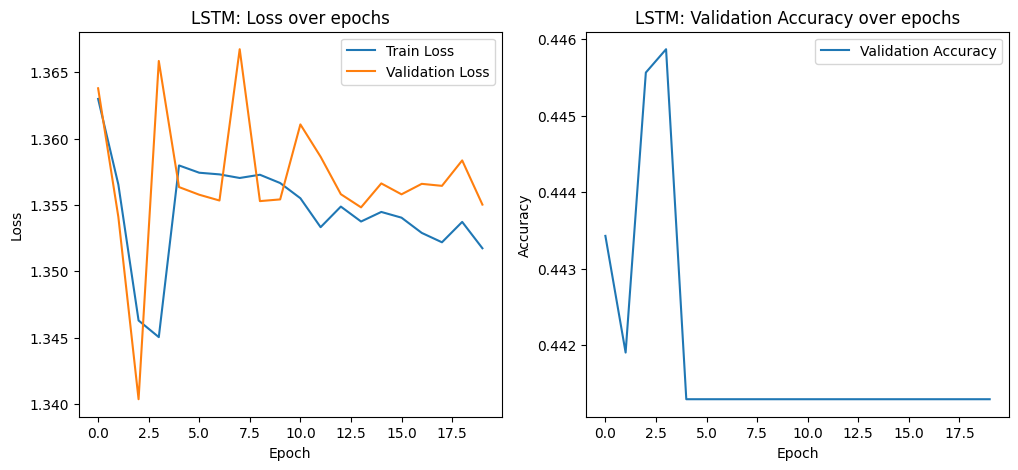

In [33]:
train_losses_lstm = []
val_losses_lstm = []
val_accuracies_lstm = []

num_epochs = 20
for epoch in range(num_epochs):
    model_lstm.train()
    losses = []
    for batch in tqdm(train_loader):
        optimizer_lstm.zero_grad()
        input_ids = batch["input_ids"].to(device)
        labels = batch["labels"].to(device)
        outputs = model_lstm(input_ids)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer_lstm.step()
        losses.append(loss.item())
    train_losses_lstm.append(np.mean(losses))

    model_lstm.eval()
    val_loss = 0
    val_steps = 0
    val_preds = []
    val_labels_list = []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            outputs = model_lstm(input_ids)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()
            val_steps += 1

            val_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            val_labels_list.extend(labels.cpu().numpy())

    val_losses_lstm.append(val_loss / val_steps)
    val_accuracy = accuracy_score(val_labels_list, val_preds)
    val_accuracies_lstm.append(val_accuracy)
    print(f'Epoch {epoch+1} / {num_epochs}, Train Loss: {np.mean(losses)}, Validation Loss: {val_loss / val_steps}, Validation Accuracy: {val_accuracy}')

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses_lstm, label='Train Loss')
plt.plot(val_losses_lstm, label='Validation Loss')
plt.title('LSTM: Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies_lstm, label='Validation Accuracy')
plt.title('LSTM: Validation Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### LSTM wnioski
- dokładność około 58%
- dataset z parafrazami w niewielkim stopniu poprawił wynik
- regularyzacja nieznacznie poprawiła wynik
- zwiększenie liczby warstw nie pomogło
- uczenie dosyć niestabilne

In [ ]:
# num_epochs = 10
# for epoch in range(num_epochs):
#     model_lstm.train()
#     losses = []
#     for batch in tqdm(train_loader):
#         optimizer_lstm .zero_grad()
#         input_ids = batch["input_ids"].to(device)
#         labels = batch["labels"].to(device)
#         outputs = model_lstm(input_ids)
#         loss = loss_fn(outputs, labels)
#         loss.backward()
#         optimizer_lstm .step()
#         losses.append(loss.item())
#     print(f'Epoch {epoch+1}, Loss: {np.mean(losses)}')

In [ ]:
# model_lstm.eval()
# correct_predictions = 0
# with torch.no_grad():
#     for batch in val_loader:
#         input_ids = batch["input_ids"].to(device)
#         labels = batch["labels"].to(device)
#         outputs = model_lstm(input_ids)
#         _, preds = torch.max(outputs, dim=1)
#         correct_predictions += torch.sum(preds == labels)
# print(f'Validation Accuracy: {correct_predictions.double() / len(val_dataset)}')

In [34]:
df_test_data = pd.read_csv("test_data.csv", header=None)
test_reviews = df_test_data[0].tolist()

test_dataset = TextDataset(test_reviews, [0]*len(test_reviews), tokenizer=tokenizer)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

model_cnn.eval()
test_preds = []
with torch.no_grad():
    for batch in tqdm(test_loader):
        input_ids = batch["input_ids"].to(device)
        # attention_mask = batch["attention_mask"].to(device)
        outputs = model_cnn(input_ids)
        _, preds = torch.max(outputs, dim=1)
        test_preds.extend(preds.cpu().numpy())

results_df = pd.DataFrame(test_preds)
results_df.to_csv("poniedzialek_grądziel_misztal.csv", index=False, header=False)

100%|██████████| 33/33 [00:10<00:00,  3.25it/s]
